In [1]:
import functools

import datasets

import matplotlib.pyplot as plt

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import torchtext

In [2]:
seed = 0

torch.manual_seed(seed)

In [3]:
train_data, test_data = datasets.load_dataset('imdb', split=['train', 'test'])

Reusing dataset imdb (/home/ben/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a)


In [4]:
train_data, test_data

(Dataset({
     features: ['label', 'text'],
     num_rows: 25000
 }),
 Dataset({
     features: ['label', 'text'],
     num_rows: 25000
 }))

In [5]:
train_data[0]

{'label': 1,
 'text': 'Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High\'s satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers\' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I\'m here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn\'t!'}

In [6]:
tokenizer = torchtext.data.utils.get_tokenizer('basic_english')

In [7]:
def tokenize_data(example, tokenizer, max_length):
    tokens = tokenizer(example['text'])[:max_length]
    return {'tokens': tokens}

In [8]:
max_length = 256

train_data = train_data.map(tokenize_data, fn_kwargs={'tokenizer': tokenizer, 'max_length': max_length})
test_data = test_data.map(tokenize_data, fn_kwargs={'tokenizer': tokenizer, 'max_length': max_length})

Loading cached processed dataset at /home/ben/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a/cache-ad1b7a77180a232c.arrow
Loading cached processed dataset at /home/ben/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a/cache-01c0069c185da175.arrow


In [9]:
train_data

Dataset({
    features: ['label', 'text', 'tokens'],
    num_rows: 25000
})

In [10]:
train_data[0]

{'label': 1,
 'text': 'Bromwell High is a cartoon comedy. It ran at the same time as some other programs about school life, such as "Teachers". My 35 years in the teaching profession lead me to believe that Bromwell High\'s satire is much closer to reality than is "Teachers". The scramble to survive financially, the insightful students who can see right through their pathetic teachers\' pomp, the pettiness of the whole situation, all remind me of the schools I knew and their students. When I saw the episode in which a student repeatedly tried to burn down the school, I immediately recalled ......... at .......... High. A classic line: INSPECTOR: I\'m here to sack one of your teachers. STUDENT: Welcome to Bromwell High. I expect that many adults of my age think that Bromwell High is far fetched. What a pity that it isn\'t!',
 'tokens': ['bromwell',
  'high',
  'is',
  'a',
  'cartoon',
  'comedy',
  '.',
  'it',
  'ran',
  'at',
  'the',
  'same',
  'time',
  'as',
  'some',
  'other',


In [11]:
test_size = 0.25

train_valid_data = train_data.train_test_split(test_size=test_size)
train_data = train_valid_data['train']
valid_data = train_valid_data['test']

Loading cached split indices for dataset at /home/ben/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a/cache-90b2a85f23273ecd.arrow and /home/ben/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a/cache-99371bdf1a536e7c.arrow


In [12]:
train_data[0]

{'label': 1,
 'text': "Made in 1946 and released in 1948, The Lady and Shanghai was one of the big films made by Welles after returning from relative exile for making Citizen Kane. Dark, brooding and expressing some early Cold War paranoia, this film stands tall as a Film-Noir crime film. The cinematography of this film is filled with Welles' characteristic quirks of odd angles, quick cuts, long pans and sinister lighting. The use of ambient street music is a precursor to the incredible long opening shot in Touch of Evil, and the mysterious Chinese characters and the sequences in Chinatown can only be considered as the inspiration, in many ways, to Roman Polanski's Chinatown. Unfortunately, it is Welles' obsession with technical filmmaking that hurts this film in its entirety. The plot of this story is often lost behind a sometimes incomprehensible clutter of film techniques.<br /><br />However, despite this criticism, the story combined with wonderful performances by Welles, Hayworth 

In [13]:
len(train_data), len(valid_data), len(test_data)

(18750, 6250, 25000)

In [14]:
min_freq = 5
special_tokens = ['<unk>', '<pad>']

vocab = torchtext.vocab.build_vocab_from_iterator(train_data['tokens'],
                                                  min_freq=min_freq,
                                                  specials=special_tokens)

In [15]:
len(vocab)

21543

In [16]:
vocab.get_itos()[:10]

['<unk>', '<pad>', 'the', '.', ',', 'a', 'and', 'of', 'to', "'"]

In [17]:
unk_index = vocab['<unk>']

unk_index

0

In [18]:
pad_index = vocab['<pad>']

pad_index

1

In [19]:
'some_token' in vocab

False

In [20]:
vocab.set_default_index(unk_index)

In [21]:
vocab['some_token']

0

In [22]:
def numericalize_data(example, vocab):
    ids = [vocab[token] for token in example['tokens']]
    return {'ids': ids}

In [23]:
train_data = train_data.map(numericalize_data, fn_kwargs={'vocab': vocab})
valid_data = valid_data.map(numericalize_data, fn_kwargs={'vocab': vocab})
test_data = test_data.map(numericalize_data, fn_kwargs={'vocab': vocab})

Loading cached processed dataset at /home/ben/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a/cache-4fa96f7122a515e2.arrow
Loading cached processed dataset at /home/ben/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a/cache-cabd43c688223ded.arrow
Loading cached processed dataset at /home/ben/.cache/huggingface/datasets/imdb/plain_text/1.0.0/e3c66f1788a67a89c7058d97ff62b6c30531e05b549de56d3ab91891f0561f9a/cache-087b09fd94e05553.arrow


In [24]:
train_data[0]

{'label': 1,
 'text': "Made in 1946 and released in 1948, The Lady and Shanghai was one of the big films made by Welles after returning from relative exile for making Citizen Kane. Dark, brooding and expressing some early Cold War paranoia, this film stands tall as a Film-Noir crime film. The cinematography of this film is filled with Welles' characteristic quirks of odd angles, quick cuts, long pans and sinister lighting. The use of ambient street music is a precursor to the incredible long opening shot in Touch of Evil, and the mysterious Chinese characters and the sequences in Chinatown can only be considered as the inspiration, in many ways, to Roman Polanski's Chinatown. Unfortunately, it is Welles' obsession with technical filmmaking that hurts this film in its entirety. The plot of this story is often lost behind a sometimes incomprehensible clutter of film techniques.<br /><br />However, despite this criticism, the story combined with wonderful performances by Welles, Hayworth 

In [25]:
train_data = train_data.with_format(type='torch', columns=['ids', 'label'])
valid_data = valid_data.with_format(type='torch', columns=['ids', 'label'])
test_data = test_data.with_format(type='torch', columns=['ids', 'label'])

Same thing as `set_format`, but not in-place.

In [26]:
train_data[0]

{'label': tensor(1),
 'ids': tensor([   98,    13,  6329,     6,   559,    13,  6491,     4,     2,   763,
             6,  6300,    17,    34,     7,     2,   195,   116,    98,    40,
          2302,   102,  3497,    44,  3318, 15422,    21,   261,  3609,  3433,
             3,   474,     4,  6093,     6, 10888,    54,   396,  1198,   338,
          4479,     4,    14,    23,  1481,  3596,    19,     5, 13453,   850,
            23,     3,     2,   639,     7,    14,    23,    10,  1073,    20,
          2302,     9,  7180,  9372,     7,  1045,  2522,     4,  1706,  2115,
             4,   212,  8127,     6,  3179,  1485,     3,     2,   386,     7,
         13210,   860,   233,    10,     5, 12948,     8,     2,   984,   212,
           628,   346,    13,  1228,     7,   462,     4,     6,     2,  1236,
          1675,   114,     6,     2,   905,    13, 10802,    59,    71,    35,
          1132,    19,     2,  3009,     4,    13,   117,   771,     4,     8,
          3582,  3534,  

Use `output_all_columns=True` to keep non-converted columns.

In [27]:
class NBoW(nn.Module):
    def __init__(self, vocab_size, embedding_dim, output_dim, pad_index):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim, padding_idx=pad_index)
        self.fc = nn.Linear(embedding_dim, output_dim)

    def forward(self, ids):
        # ids = [batch size, seq len]
        embedded = self.embedding(ids)
        # embedded = [batch size, seq len, embedding dim]
        pooled = embedded.mean(dim=1)
        # pooled = [batch size, embedding dim]
        prediction = self.fc(pooled)
        # prediction = [batch size, output dim]
        return prediction

In [28]:
vocab_size = len(vocab)
embedding_dim = 300
output_dim = len(train_data.unique('label'))

model = NBoW(vocab_size, embedding_dim, output_dim, pad_index)

In [29]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 6,463,502 trainable parameters


In [30]:
vectors = torchtext.vocab.FastText()

In [31]:
hello_vector = vectors.get_vecs_by_tokens('hello')

In [32]:
hello_vector.shape

torch.Size([300])

In [33]:
hello_vector

tensor([-1.5945e-01, -1.8259e-01,  3.3443e-02,  1.8813e-01, -6.7903e-02,
        -1.3663e-01, -2.5559e-01,  1.1000e-01,  1.7275e-01,  5.1971e-02,
        -2.3302e-02,  3.8866e-02, -2.4515e-01, -2.1588e-01,  3.5925e-01,
        -8.2526e-02,  1.2176e-01, -2.6775e-01,  1.0072e-01, -1.3639e-01,
        -9.2658e-02,  5.1837e-01,  1.7736e-01,  9.4878e-02, -1.8461e-01,
        -4.2829e-02,  1.4114e-02,  1.6811e-01, -1.8565e-01,  3.4976e-02,
        -1.0293e-01,  1.7954e-01, -5.2766e-02,  7.2047e-02, -4.2704e-01,
        -1.1616e-01, -9.4875e-03,  1.4199e-01, -2.2782e-01, -1.7292e-02,
         8.2802e-02, -4.4512e-01, -7.5935e-02, -1.4392e-01, -8.2461e-02,
         2.0123e-01, -9.5344e-02, -1.1042e-01, -4.6817e-01,  2.0362e-01,
        -1.7140e-01, -4.9850e-01,  2.8963e-01, -1.0305e-01,  2.0393e-01,
         5.2971e-01, -2.5396e-01, -5.1891e-01,  2.9941e-01,  1.7933e-01,
         3.0683e-01,  2.5828e-01, -1.8168e-01, -1.0225e-01, -1.1435e-01,
        -1.6304e-01, -1.2424e-01,  3.2814e-01, -2.3

In [34]:
pretrained_embedding = vectors.get_vecs_by_tokens(vocab.get_itos())

In [35]:
pretrained_embedding.shape

torch.Size([21543, 300])

In [36]:
model.embedding.weight

Parameter containing:
tensor([[-1.1258, -1.1524, -0.2506,  ...,  0.8200, -0.6332,  1.2948],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.1483,  2.4187,  1.3279,  ..., -1.0328,  1.1305, -0.5703],
        ...,
        [-0.9882, -0.5407,  1.2382,  ...,  2.4935,  1.0714, -0.7917],
        [-1.2230,  0.6308,  1.7523,  ...,  0.9265, -0.1116, -0.3872],
        [-1.6577,  0.1200, -0.0599,  ..., -0.5380,  0.5277, -0.0379]],
       requires_grad=True)

In [37]:
pretrained_embedding

tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0653, -0.0930, -0.0176,  ...,  0.1664, -0.1308,  0.0354],
        ...,
        [-0.1329,  0.2494, -0.3875,  ...,  0.3734,  0.4520, -0.2060],
        [-0.6976,  0.2878,  0.0754,  ...,  0.4601, -0.4200, -0.2361],
        [ 0.1161, -0.0390,  0.1120,  ...,  0.0925, -0.1058,  0.5641]])

In [38]:
model.embedding.weight.data = pretrained_embedding

In [39]:
model.embedding.weight

Parameter containing:
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [-0.0653, -0.0930, -0.0176,  ...,  0.1664, -0.1308,  0.0354],
        ...,
        [-0.1329,  0.2494, -0.3875,  ...,  0.3734,  0.4520, -0.2060],
        [-0.6976,  0.2878,  0.0754,  ...,  0.4601, -0.4200, -0.2361],
        [ 0.1161, -0.0390,  0.1120,  ...,  0.0925, -0.1058,  0.5641]],
       requires_grad=True)

In [40]:
optimizer = optim.Adam(model.parameters())

In [41]:
criterion = nn.CrossEntropyLoss()

In [42]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

In [43]:
model = model.to(device)
criterion = criterion.to(device)

In [44]:
def collate(batch, pad_index):
    batch_ids = [i['ids'] for i in batch]
    batch_ids = nn.utils.rnn.pad_sequence(batch_ids, padding_value=pad_index, batch_first=True)
    batch_label = [i['label'] for i in batch]
    batch_label = torch.stack(batch_label)
    batch = {'ids': batch_ids,
             'label': batch_label}
    return batch

In [45]:
batch_size = 512

collate = functools.partial(collate, pad_index=pad_index)

train_dataloader = torch.utils.data.DataLoader(train_data, 
                                               batch_size=batch_size, 
                                               collate_fn=collate, 
                                               shuffle=True)

valid_dataloader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, collate_fn=collate)
test_dataloader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, collate_fn=collate)

In [46]:
def train(dataloader, model, criterion, optimizer, device):

    model.train()
    epoch_losses = []
    epoch_accs = []

    for batch in dataloader:
        ids = batch['ids'].to(device)
        label = batch['label'].to(device)
        prediction = model(ids)
        loss = criterion(prediction, label)
        accuracy = get_accuracy(prediction, label)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        epoch_losses.append(loss.item())
        epoch_accs.append(accuracy.item())

    return epoch_losses, epoch_accs

In [47]:
def evaluate(dataloader, model, criterion, device):
    
    model.eval()
    epoch_losses = []
    epoch_accs = []

    with torch.no_grad():
        for batch in dataloader:
            ids = batch['ids'].to(device)
            label = batch['label'].to(device)
            prediction = model(ids)
            loss = criterion(prediction, label)
            accuracy = get_accuracy(prediction, label)
            epoch_losses.append(loss.item())
            epoch_accs.append(accuracy.item())

    return epoch_losses, epoch_accs

In [48]:
def get_accuracy(prediction, label):
    batch_size, _ = prediction.shape
    predicted_classes = prediction.argmax(dim=-1)
    correct_predictions = predicted_classes.eq(label).sum()
    accuracy = correct_predictions / batch_size
    return accuracy

In [49]:
n_epochs = 10
best_valid_loss = float('inf')

train_losses = []
train_accs = []
valid_losses = []
valid_accs = []

for epoch in range(n_epochs):

    train_loss, train_acc = train(train_dataloader, model, criterion, optimizer, device)
    valid_loss, valid_acc = evaluate(valid_dataloader, model, criterion, device)

    train_losses.extend(train_loss)
    train_accs.extend(train_acc)
    valid_losses.extend(valid_loss)
    valid_accs.extend(valid_acc)
    
    epoch_train_loss = np.mean(train_loss)
    epoch_train_acc = np.mean(train_acc)
    epoch_valid_loss = np.mean(valid_loss)
    epoch_valid_acc = np.mean(valid_acc)
    
    if epoch_valid_loss < best_valid_loss:
        best_valid_loss = epoch_valid_loss
        torch.save(model.state_dict(), 'nbow.pt')
    
    print(f'epoch: {epoch+1}')
    print(f'train_loss: {epoch_train_loss:.3f}, train_acc: {epoch_train_acc:.3f}')
    print(f'valid_loss: {epoch_valid_loss:.3f}, valid_acc: {epoch_valid_acc:.3f}')

epoch: 1
train_loss: 0.684, train_acc: 0.604
valid_loss: 0.671, valid_acc: 0.682
epoch: 2
train_loss: 0.648, train_acc: 0.718
valid_loss: 0.627, valid_acc: 0.729
epoch: 3
train_loss: 0.588, train_acc: 0.764
valid_loss: 0.567, valid_acc: 0.769
epoch: 4
train_loss: 0.516, train_acc: 0.807
valid_loss: 0.504, valid_acc: 0.803
epoch: 5
train_loss: 0.446, train_acc: 0.847
valid_loss: 0.450, valid_acc: 0.833
epoch: 6
train_loss: 0.388, train_acc: 0.870
valid_loss: 0.411, valid_acc: 0.844
epoch: 7
train_loss: 0.343, train_acc: 0.886
valid_loss: 0.384, valid_acc: 0.852
epoch: 8
train_loss: 0.308, train_acc: 0.899
valid_loss: 0.364, valid_acc: 0.857
epoch: 9
train_loss: 0.280, train_acc: 0.909
valid_loss: 0.349, valid_acc: 0.862
epoch: 10
train_loss: 0.257, train_acc: 0.917
valid_loss: 0.336, valid_acc: 0.867


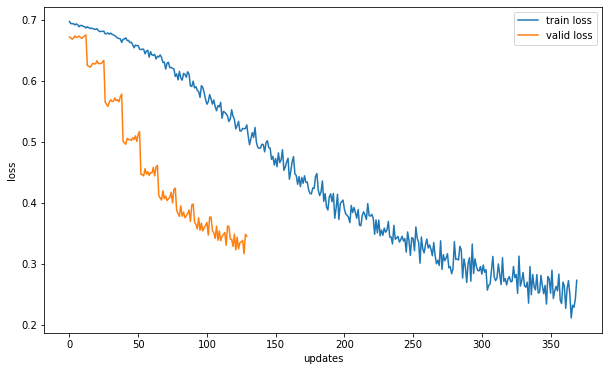

In [50]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(train_losses, label='train loss')
ax.plot(valid_losses, label='valid loss')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('loss');

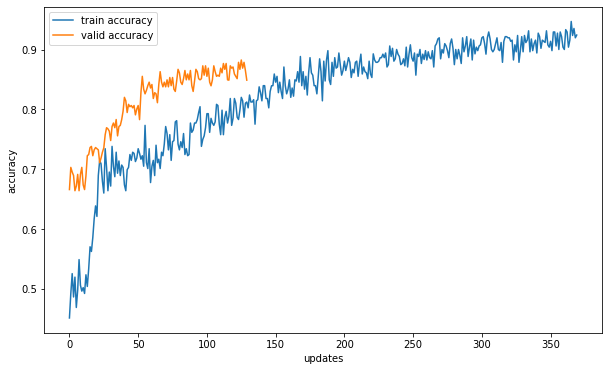

In [51]:
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(1,1,1)
ax.plot(train_accs, label='train accuracy')
ax.plot(valid_accs, label='valid accuracy')
plt.legend()
ax.set_xlabel('updates')
ax.set_ylabel('accuracy');

In [52]:
model.load_state_dict(torch.load('nbow.pt'))

test_loss, test_acc = evaluate(test_dataloader, model, criterion, device)

epoch_test_loss = np.mean(test_loss)
epoch_test_acc = np.mean(test_acc)

print(f'test_loss: {epoch_test_loss:.3f}, test_acc: {epoch_test_acc:.3f}')

test_loss: 0.353, test_acc: 0.857


In [53]:
def predict_sentiment(text, model, tokenizer, vocab, device):
    tokens = tokenizer(text)
    ids = [vocab[t] for t in tokens]
    tensor = torch.LongTensor(ids).unsqueeze(dim=0).to(device)
    prediction = model(tensor).squeeze(dim=0)
    probability = torch.softmax(prediction, dim=-1)
    predicted_class = prediction.argmax(dim=-1).item()
    predicted_probability = probability[predicted_class].item()
    return predicted_class, predicted_probability

In [54]:
text = "This film is terrible!"

predict_sentiment(text, model, tokenizer, vocab, device)

(0, 0.9999740123748779)

In [55]:
text = "This film is great!"

predict_sentiment(text, model, tokenizer, vocab, device)

(1, 0.9999997615814209)

In [56]:
text = "This film is not terrible, it's great!"

predict_sentiment(text, model, tokenizer, vocab, device)

(1, 0.765370786190033)

In [57]:
text = "This film is not great, it's terrible!"

predict_sentiment(text, model, tokenizer, vocab, device)

(1, 0.765370786190033)